In [122]:
import importlib
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import tqdm

import utils
import filters
import modules

importlib.reload(utils)
importlib.reload(filters)
importlib.reload(modules)

device = "cpu"
device


'cpu'

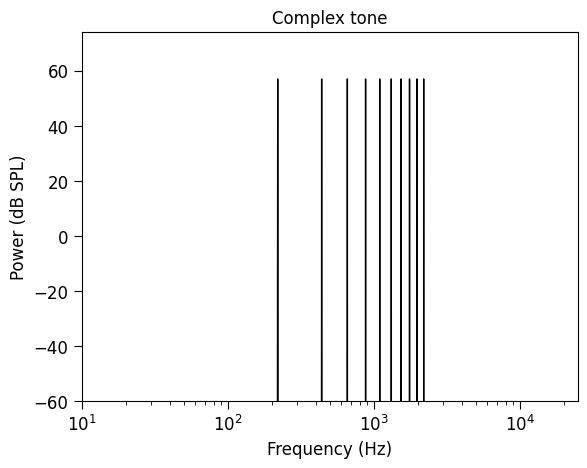

In [125]:
sr = 50e3
x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.5,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 11),
    amplitudes=0.02,
)

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(x, sr=sr, scaling="spectrum")
ax.plot(fxx, pxx, color="k", lw=1)
utils.format_axes(
    ax,
    str_title="Complex tone",
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    xscale="log",
    yscale="linear",
    xlimits=[10, sr / 2],
    ylimits=[-60, None],
)
plt.show()

# fig, ax = utils.make_periodogram_plot(x, sr, str_title="Complex tone")

ipd.display(ipd.Audio(rate=sr, data=x))


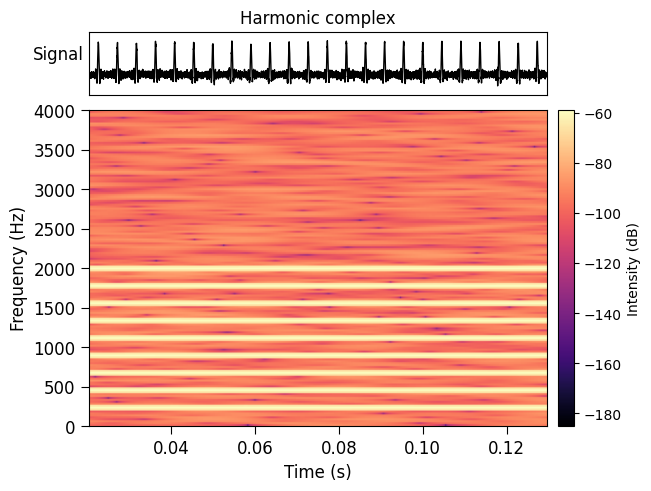

In [126]:
sr = 50e3
x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.15,
    f0=220,
    phase="cosine",
    harmonics=np.arange(1, 10),
)
x = utils.set_dbspl(x, 60)
x += utils.set_dbspl(np.random.randn(*x.shape), 45)

utils.make_spectrogram_plot(
    x,
    sr,
    nfft=2048,
    ylimits=[0, 4e3],
    str_title="Harmonic complex",
)
plt.show()


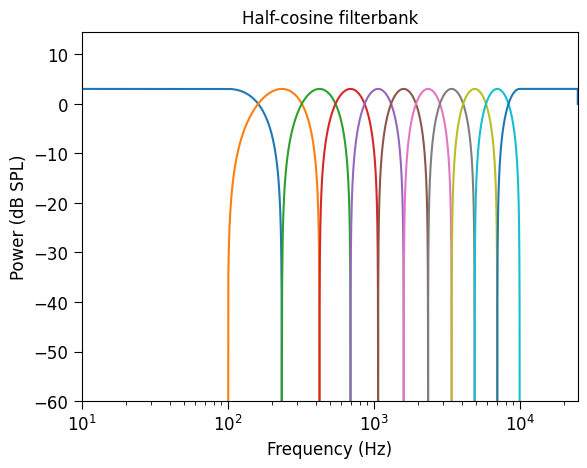

In [127]:
sr = 50000
filterbank = modules.HalfCosineFilterbank(
    sr=50000,
    cf_low=1e2,
    cf_high=1e4,
    cf_num=11,
    scale="erb",
    include_highpass=True,
    include_lowpass=True,
).to(device)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device).float().unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Half-cosine filterbank",
)
plt.show()


(50, 50000)


/Users/marksa/Desktop/auditory_model_tutorial/utils.py:99: RuntimeWarning: divide by zero encountered in log10
  pxx = 10.0 * np.log10(pxx / np.square(p_ref))


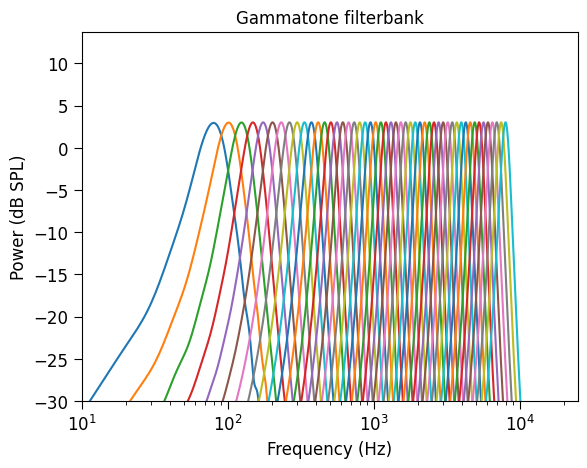

In [128]:
sr = 50000
filterbank = modules.GammatoneFilterbank(
    sr=sr,
    fir_dur=0.05,
    cfs=utils.erbspace(8e1, 8e3, 50),
    dtype=torch.float32,
    bw_mult=1,
).to(device)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device).float().unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Gammatone filterbank",
    ylimits=[-30, None],
)
plt.show()


(50000,)


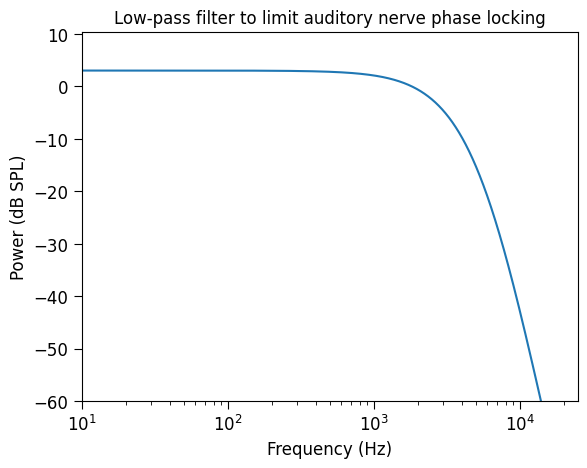

In [129]:
sr = 50000
filterbank = modules.IHCLowpassFilter(
    sr_input=sr,
    sr_output=sr,
    fir_dur=0.05,
    cutoff=3e3,
    order=7,
).to(device)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device).float().unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Low-pass filter to limit auditory nerve phase locking",
)
plt.show()


(500, 500)


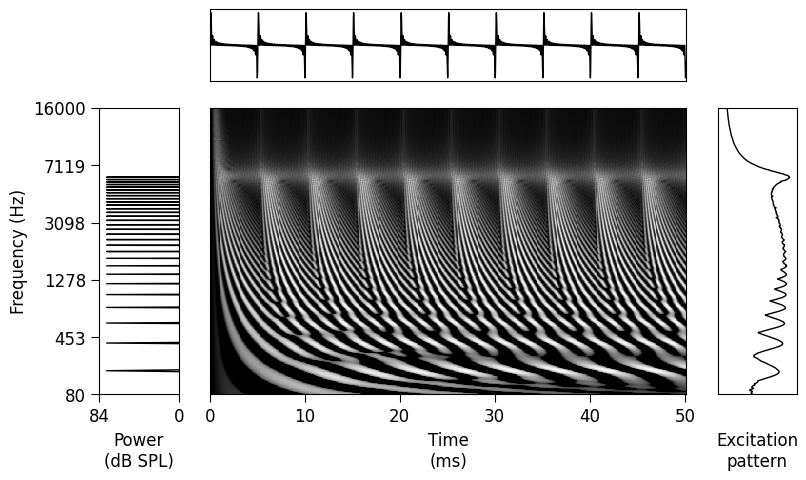

In [130]:
importlib.reload(utils)

class CochlearModel(torch.nn.Module):
    def __init__(
        self,
        sr_input=50000,
        sr_output=10000,
        cfs=utils.erbspace(8e1, 16e3, 100),
        fir_dur=0.05,
        compression_power=0.3,
        bw_mult=1.0,
    ):
        """
        Simple cochlear model.

        Args
        ----
        sr_input (int):
            Sampling rate of the input sound waveform.
        sr_output (int):
            Sampling rate of the output representation.
        cfs (np.ndarray):
            Characteristic frequencies of the cochlear filters
        fir_dur (float):
            Duration of the filter FIRs in seconds.
        compression_power (float):
            Power of the compression applied to filterbank outputs.
        bw_mult (float):
            Scales cochlear filter bandwidths
        """
        super().__init__()
        self.sr_input = sr_input
        self.sr_output = sr_output
        self.cfs = cfs
        self.cochlear_filterbank = modules.GammatoneFilterbank(
            sr=sr_input,
            fir_dur=fir_dur,
            cfs=self.cfs,
            dtype=torch.float32,
            bw_mult=bw_mult,
        )
        # self.compression_power = torch.as_tensor(compression_power, dtype=torch.float32)
        self.register_buffer(
            "compression_power",
            torch.as_tensor(compression_power, dtype=torch.float32),
        )
        self.ihc_lowpass_filter = modules.IHCLowpassFilter(
            sr_input=sr_input,
            sr_output=sr_output,
            fir_dur=fir_dur,
            cutoff=3e3,
            order=7,
        )

    def forward(self, x):
        """
        Run the cochlear model on an input sound waveform.

        Args
        ----
        x (torch.Tensor):
            Input sound waveform. Shape (batch_size, num_samples).

        Returns
        -------
        x (torch.Tensor):
            Output of the cochlear model. Shape (batch_size, frequency_channels, num_samples).
        """
        x = self.cochlear_filterbank(x)
        x = torch.nn.functional.relu(x)
        # x = torch.pow(x, self.compression_power.view(-1, 1))
        x = modules.GradientClippedPower.apply(
            x,
            self.compression_power.view(-1, 1),
            1.0,
        )
        x = self.ihc_lowpass_filter(x)
        x = torch.nn.functional.relu(x)
        return x



cfs = utils.erbspace(8e1, 16e3, 500)
# compression_power = np.linspace(1.0, 1.0, cfs.shape[0])
compression_power = 0.3
bw_mult = np.ones_like(cfs) * 1
cochlear_model = CochlearModel(
    cfs=cfs,
    compression_power=compression_power,
    bw_mult=bw_mult,
).to(device)

x = utils.harmonic_complex_tone(
    sr=cochlear_model.sr_input,
    dur=0.05,
    f0=200,
    phase="sine",
    harmonics=np.arange(1, 31, 1),
    amplitudes=0.2,
)
x_tensor = torch.as_tensor(x, device=device).float().unsqueeze(0)
x_nervegram_tensor = cochlear_model(x_tensor).squeeze(0)
x_nervegram = x_nervegram_tensor.detach().cpu().numpy()
print(x_nervegram.shape)

fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram,
    sr_waveform=cochlear_model.sr_input,
    sr_nervegram=cochlear_model.sr_output,
    cfs=cochlear_model.cfs,
)
plt.show()


In [131]:
for _ in tqdm.tqdm(range(10)):
    cochlear_model(x_tensor).squeeze(0)


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


/Users/marksa/Desktop/auditory_model_tutorial/modules.py:173: RuntimeWarning: divide by zero encountered in log
  f = np.log(f)


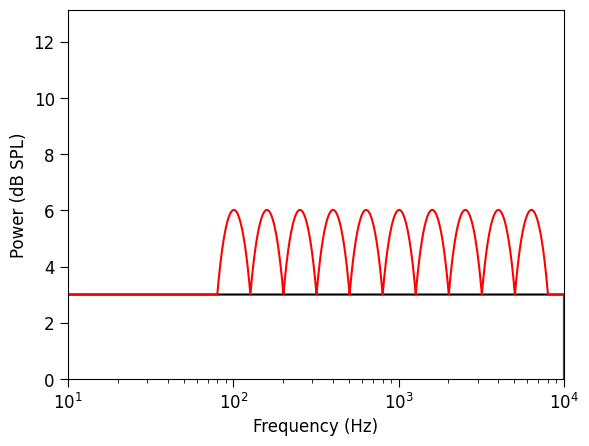

In [132]:
importlib.reload(modules)

class HearingAid(torch.nn.Module):
    def __init__(self, sr=50000):
        super().__init__()
        self.filterbank = modules.HalfCosineFilterbank(
            sr=sr,
            cf_low=80,
            cf_high=8000,
            cf_num=11,
            scale="log",
            include_highpass=True,
            include_lowpass=True,
        )
        self.gains = torch.nn.parameter.Parameter(
            data=torch.zeros(self.filterbank.cf_num),
            requires_grad=True,
        )
    
    def forward(self, x):
        y = self.filterbank(x)
        y = y * torch.pow(10, self.gains / 10).view(1, -1, 1)
        y = torch.sum(y, axis=1)
        return y


sr = 20e3
hearing_aid = HearingAid(sr=sr)

x = torch.zeros(1, 50000)
x[:, 0] = 1
y = hearing_aid(x)

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(x[0].detach().cpu().numpy(), sr)
fyy, pyy = utils.periodogram(y[0].detach().cpu().numpy(), sr)
ax.plot(fxx, pxx, "k")
ax.plot(fyy, pyy, "r")
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[0, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
)
plt.show()


In [133]:
cfs = utils.erbspace(8e1, 8e3, 100)

healthy_cochlear_model = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    compression_power=0.3,
    bw_mult=1.0,
).to(device)

impaired_cochlear_model = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    compression_power=np.linspace(0.3, 1.0, 100),
    bw_mult=1.0,
).to(device)

def loss_function(x_healthy, x_impaired):
    y_healthy = healthy_cochlear_model(x_healthy)
    y_impaired = impaired_cochlear_model(x_impaired)
    # loss = torch.nn.functional.mse_loss(y_impaired, y_healthy)
    loss = torch.nn.functional.l1_loss(y_impaired, y_healthy)
    return loss

hearing_aid = HearingAid(sr=sr)
for n, p in hearing_aid.named_parameters():
    print(n, p)


gains Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


In [134]:
for n, p in hearing_aid.named_parameters():
    print(n, p)

with torch.autograd.set_detect_anomaly(True):
    num_steps = 500
    optimizer = torch.optim.Adam(
        params=list(hearing_aid.parameters()),
        lr=1e-1,
    )
    pbar = tqdm.tqdm(range(num_steps))
    for step in pbar:
        # x = utils.harmonic_complex_tone(
        #     sr=sr,
        #     dur=0.05,
        #     f0=220,
        #     phase="sine",
        #     harmonics=np.arange(1, 41),
        # )
        # x = utils.set_dbspl(x, 60.0)
        # x = torch.as_tensor(x[None, ...], dtype=torch.float32)

        x = torch.randn(1, 500, device=device)
        
        optimizer.zero_grad()
        x_hearing_aid = hearing_aid(x)
        loss = loss_function(x_healthy=x, x_impaired=x_hearing_aid)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({"loss": "{:0.4f}".format(loss.item())})

for n, p in hearing_aid.named_parameters():
    print(n, p)


gains Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


100%|██████████| 500/500 [00:13<00:00, 36.65it/s, loss=0.0516]

gains Parameter containing:
tensor([ 1.0197, -0.2120,  1.1006,  2.2210,  2.5860,  3.6268,  3.7622,  3.6103,
         3.3916,  3.0002,  2.5020], requires_grad=True)


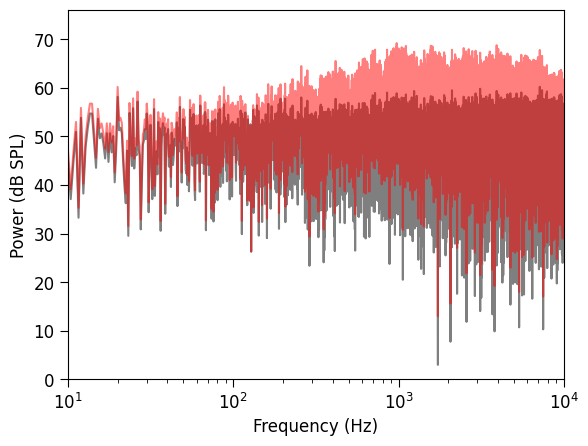

In [137]:
x = torch.randn(1, 50000)
y = hearing_aid(x)

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(x[0].detach().cpu().numpy(), sr)
fyy, pyy = utils.periodogram(y[0].detach().cpu().numpy(), sr)
ax.plot(fxx, pxx, "k", alpha=0.5)
ax.plot(fyy, pyy, "r", alpha=0.5)
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[0, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
)
plt.show()

ipd.display(ipd.Audio(rate=sr, data=x[0].detach().cpu().numpy()))
ipd.display(ipd.Audio(rate=sr, data=y[0].detach().cpu().numpy()))



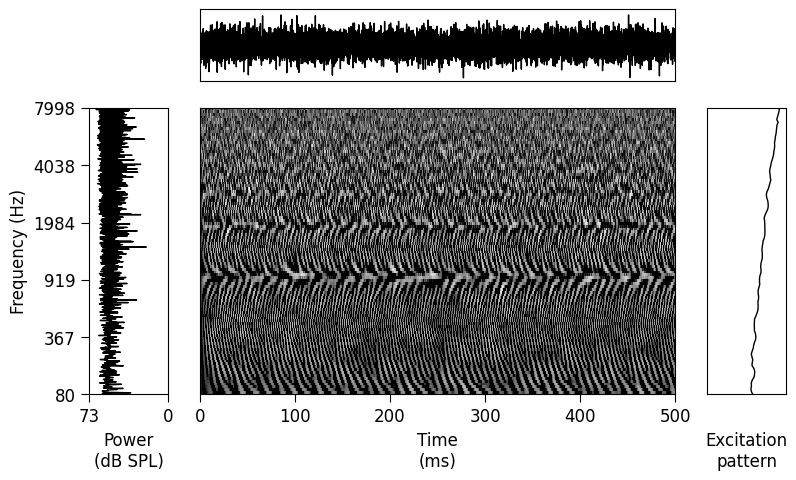

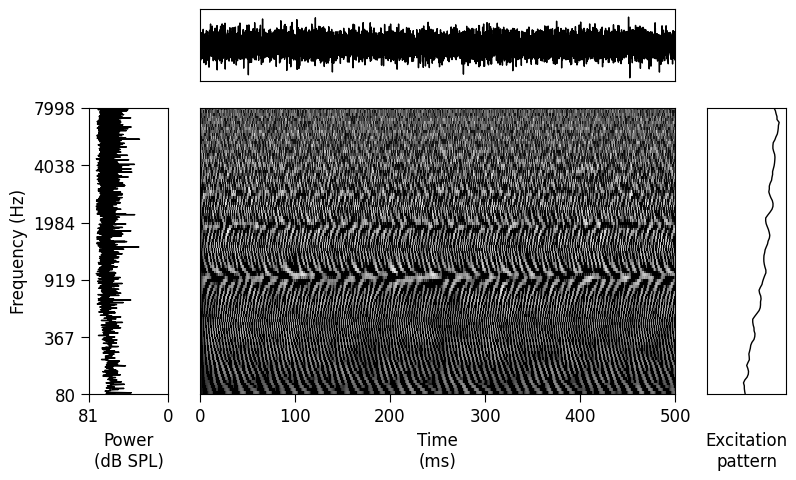

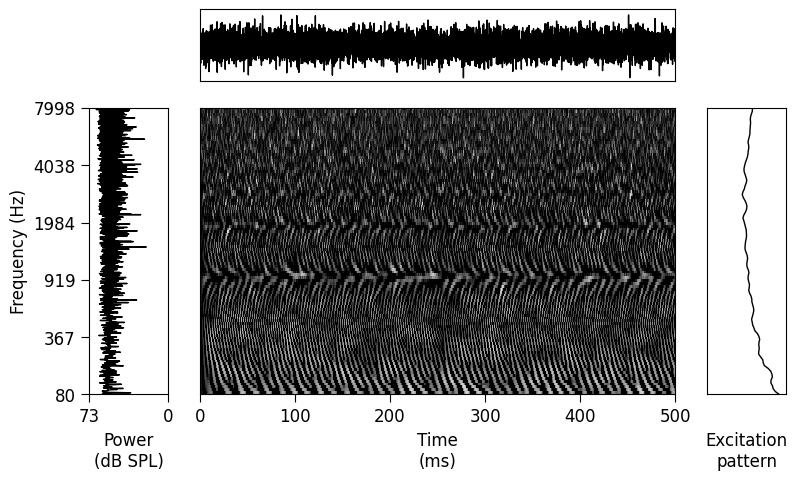

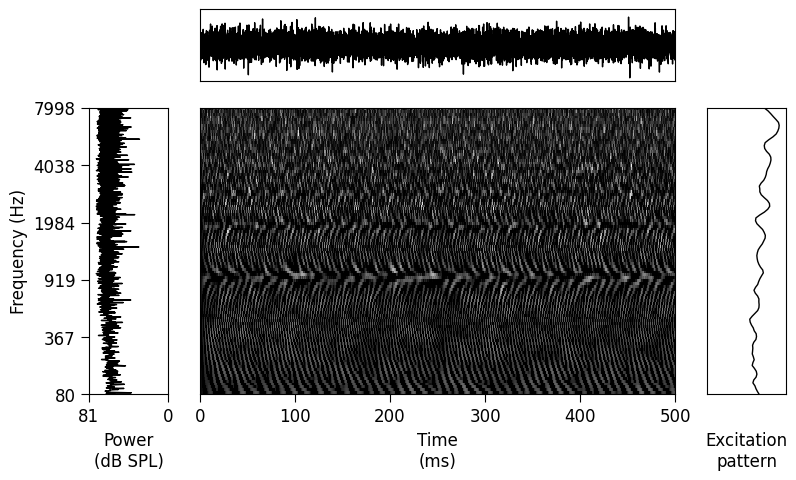

In [141]:
# x = utils.harmonic_complex_tone(
#     sr=sr,
#     dur=0.05,
#     f0=175,
#     phase="sine",
#     harmonics=np.arange(1, 41),
# )
x = np.random.randn(10000)
# x = utils.set_dbspl(x, 60.0)
x = torch.as_tensor(x[None, ...], dtype=torch.float32)
x_aided = hearing_aid(x)


nervegram_x = healthy_cochlear_model(x)[0].detach().cpu().numpy()
nervegram_x_aided = healthy_cochlear_model(x_aided)[0].detach().cpu().numpy()
nervegram_x_impaired = impaired_cochlear_model(x)[0].detach().cpu().numpy()
nervegram_x_impaired_aided = impaired_cochlear_model(x_aided)[0].detach().cpu().numpy()

fig, ax_arr = utils.make_nervegram_plot(
    waveform=x[0].detach().cpu().numpy(),
    nervegram=nervegram_x,
    sr_waveform=healthy_cochlear_model.sr_input,
    sr_nervegram=healthy_cochlear_model.sr_output,
    cfs=healthy_cochlear_model.cfs,
)
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x_aided[0].detach().cpu().numpy(),
    nervegram=nervegram_x_aided,
    sr_waveform=healthy_cochlear_model.sr_input,
    sr_nervegram=healthy_cochlear_model.sr_output,
    cfs=healthy_cochlear_model.cfs,
)
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x[0].detach().cpu().numpy(),
    nervegram=nervegram_x_impaired,
    sr_waveform=healthy_cochlear_model.sr_input,
    sr_nervegram=healthy_cochlear_model.sr_output,
    cfs=healthy_cochlear_model.cfs,
)
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x_aided[0].detach().cpu().numpy(),
    nervegram=nervegram_x_impaired_aided,
    sr_waveform=healthy_cochlear_model.sr_input,
    sr_nervegram=healthy_cochlear_model.sr_output,
    cfs=healthy_cochlear_model.cfs,
)
plt.show()
